In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
import random

GRID_SIZE = 30
ACTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)]
N_ACTIONS = 5
ALPHA = 0.3
GAMMA = 0.80
EPSILON_INITIAL = 0.3  # Alto para exploración inicial
EPSILON_MIN = 0.05  # Mínimo para explotación
DECAY_RATE = 0.001  # Baja gradual (ajusta: más alto = decay más rápido)
PATIENCE = 35000  # Early stopping: Para si no mejora 
MAX_STEPS = 500
EPISODIOS = 70001
print("Setup listo.")

Setup listo.


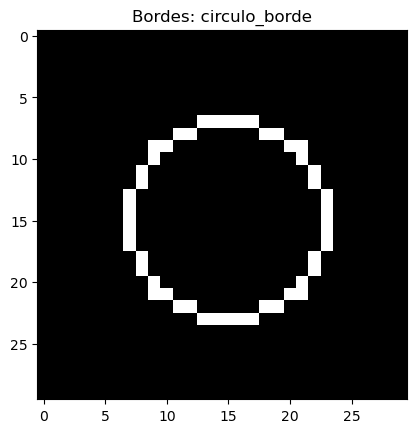

Figura: circulo_borde


In [9]:
class Figura:
    def __init__(self, size=GRID_SIZE):
        self.size = size
        self.target = np.zeros((size, size))

    def generar_borde_circulo(self, centro=(15, 15), radio=8):
        self.target.fill(0)
        y, x = np.ogrid[:self.size, :self.size]
        mask = np.abs(np.sqrt((x - centro[1])**2 + (y - centro[0])**2) - radio) < 0.5  # ¡Más delgado: <0.5!
        self.target[mask] = 1
        self.nombre = 'circulo_borde'
        return self.target

    def generar_borde_cuadrado(self, topleft=(10, 10), side=10):
        self.target.fill(0)
        self.target[topleft[0]:topleft[0]+side, topleft[1]] = 1
        self.target[topleft[0]:topleft[0]+side, topleft[1]+side-1] = 1
        self.target[topleft[0], topleft[1]:topleft[1]+side] = 1
        self.target[topleft[0]+side-1, topleft[1]:topleft[1]+side] = 1
        self.nombre = 'cuadrado_borde'
        return self.target

    def generar_borde_triangulo(self, apex=(5, 15), base_width=20, height=15):  # Pico arriba, base abajo
        self.target.fill(0)
        # Pico (topo)
        self.target[apex[0], apex[1]] = 1
        # Lado izquierdo (expande hacia abajo)
        for i in range(1, height):
            x_left = apex[1] - int((base_width // 2) * (i / height))
            self.target[apex[0] + i, x_left] = 1
        # Lado derecho (expande hacia abajo)
        for i in range(1, height):
            x_right = apex[1] + int((base_width // 2) * (i / height))
            self.target[apex[0] + i, x_right] = 1
        # Base horizontal abajo
        base_y = apex[0] + height - 1
        self.target[base_y, apex[1] - base_width//2 : apex[1] + base_width//2] = 1
        self.nombre = 'triangulo_borde'
        return self.target
    
    #Nuevas figuras de borde
    def generar_borde_rectangulo(self, topleft=(8, 8), width=11, height=20):
        self.target.fill(0)
        self.target[topleft[0]:topleft[0]+height, topleft[1]] = 1  # Izq
        self.target[topleft[0]:topleft[0]+height, topleft[1]+width-1] = 1  # Der
        self.target[topleft[0], topleft[1]:topleft[1]+width] = 1  # Arriba
        self.target[topleft[0]+height-1, topleft[1]:topleft[1]+width] = 1  # Abajo
        self.nombre = 'rectangulo_borde'
        return self.target

    # Nueva: Línea borde (para suelo, ramas)
    def generar_borde_linea(self, start=(25, 5), end=(25, 25)):
        self.target.fill(0)
        y_start, x_start = start
        y_end, x_end = end
        if y_start == y_end:  # Horizontal
            self.target[y_start, x_start:x_end] = 1
        else:  # Vertical
            self.target[y_start:y_end, x_start] = 1
        self.nombre = 'linea_borde'
        return self.target

    def similitud(self, canvas):
        inter = np.sum(self.target * (canvas > 0))
        union = np.sum(self.target) + np.sum(canvas > 0) - inter
        return (inter / union * 100) if union > 0 else 0

    def render(self):
        plt.imshow(self.target, cmap='gray', vmin=0, vmax=1)
        plt.title(f'Bordes: {self.nombre}')
        plt.show()

fig = Figura()
fig.generar_borde_circulo()  # Cambia manual: .generar_borde_cuadrado()
fig.render()
print(f"Figura: {fig.nombre}")

In [ ]:
class Lienzo:
    def __init__(self, size=GRID_SIZE):
        self.size = size
        self.canvas = np.zeros((size, size))
        self.pos = [size // 2, size // 2]
        self.target = None
        self.target_pos = (0, 0)
        self.step_count = 0

    def reset(self):
        self.canvas = np.zeros((self.size, self.size))
        self.pos = [self.size // 2, self.size // 2]
        self.step_count = 0
        return self._get_state()

    def step(self, action, target=None):
        self.step_count += 1
        reward = -0.05

        y, x = self.pos
        in_zone = (self.target_pos[0] <= y < self.target_pos[0] + 30 and self.target_pos[1] <= x < self.target_pos[1] + 30)

        if action == 4:
            if self.canvas[y, x] == 0:
                self.canvas[y, x] = 1
                reward += 0.5  # Dibuja nuevo punto
                if in_zone:
                    reward += 3.5  # si el dibujo está en zona objetivo
                if target is not None and target.target[y, x] == 1:
                    reward += 5.0  # Bono por dibujar en lugar correcto
                else:
                    reward -= 25.5  # Más penaliza ruido
            else:
                reward -= 4.5  # Penaliza por dibujar en punto ya dibujado
        else:
            # Movimiento del agente en la cuadrícula 
            dy, dx = ACTIONS[action]
            self.pos[0] = np.clip(self.pos[0] + dy, 0, self.size - 1) 
            self.pos[1] = np.clip(self.pos[1] + dx, 0, self.size - 1)
            reward -= 0.05 # Costo por moverse
            if in_zone:
                reward += 0.09  # Pequeño bono por moverse en zona objetivo

        state = self._get_state()
        done = self.step_count >= MAX_STEPS
        if target is not None:
            sim = target.similitud(self.canvas)
            reward += sim / 20  # Sube peso densa
            if sim > 75:
                reward += 80  # Bono alto, threshold bajo
                done = True
        return state, reward, done

    def _get_state(self):
        sum_drawn = int(np.sum(self.canvas))
        return (int(self.pos[0]), int(self.pos[1]), sum_drawn)

    def render_comparison(self, target):
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(target.target, cmap='gray')
        axs[0].set_title('Target Borde')
        axs[1].imshow(self.canvas, cmap='gray')
        axs[1].set_title(f'Agente (Pasos: {self.step_count})')
        plt.show()

In [11]:
class Agente:
    def __init__(self, n_actions=N_ACTIONS):
        self.q_table = defaultdict(lambda: np.zeros(n_actions))
        self.n_actions = n_actions

    def elegir_accion(self, state, epsilon=EPSILON_INITIAL):
        if random.uniform(0, 1) < epsilon:
            return random.randint(0, self.n_actions - 1)
        return np.argmax(self.q_table[state])

    def update(self, state, action, reward, next_state, done):
        # Ecuación Unida: Q(s,a) ← Q(s,a) + α [r + γ max Q(s',a') - Q(s,a)]
        best_next = np.max(self.q_table[next_state]) if not done else 0
        td_target = reward + GAMMA * best_next
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += ALPHA * td_error

    def guardar(self, nombre):
        with open(f'q_{nombre}.pkl', 'wb') as f:
            pickle.dump(dict(self.q_table), f)
        print(f"Guardado normal: q_{nombre}.pkl")

    def guardar_best(self, best_q_dict, nombre):  # Nuevo: Guarda copia best
        with open(f'q_best_{nombre}.pkl', 'wb') as f:
            pickle.dump(best_q_dict, f)
        print(f"Guardado BEST: q_best_{nombre}.pkl (mejor precisión)")

    def cargar(self, nombre):
        try:
            with open(f'q_{nombre}.pkl', 'rb') as f:
                self.q_table = defaultdict(lambda: np.zeros(self.n_actions))
                loaded = pickle.load(f)
                for k, v in loaded.items():
                    self.q_table[k] = v
            print(f"Cargado normal: q_{nombre}.pkl")
        except FileNotFoundError:
            print("No modelo normal; entrena.")

    def cargar_best(self, nombre):  # Nuevo: Carga best
        try:
            with open(f'q_best_{nombre}.pkl', 'rb') as f:
                self.q_table = defaultdict(lambda: np.zeros(self.n_actions))
                loaded = pickle.load(f)
                for k, v in loaded.items():
                    self.q_table[k] = v
            print(f"Cargado BEST: q_best_{nombre}.pkl")
        except FileNotFoundError:
            print("No best modelo; usa cargar normal.")

Ep 0: Reward -583.30, Sim 0.0%, Pasos 500


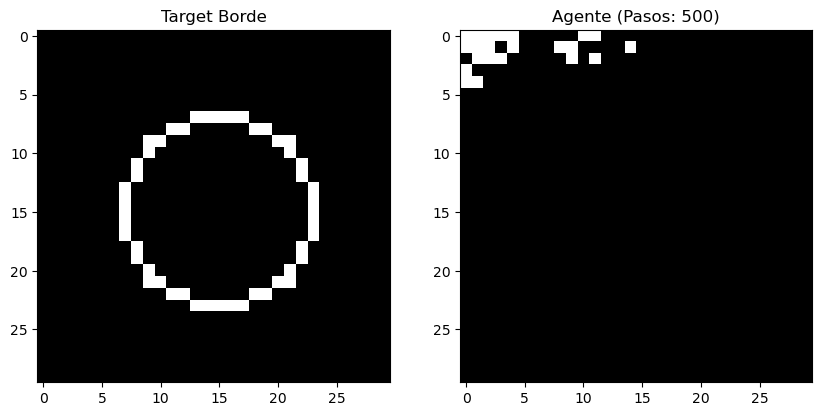

Ep 10000: Reward 980.42, Sim 36.7%, Pasos 500


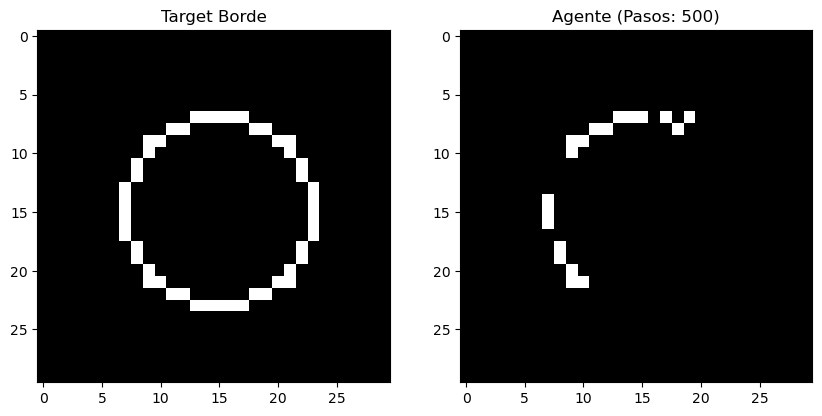

Ep 20000: Reward 1058.39, Sim 42.3%, Pasos 500


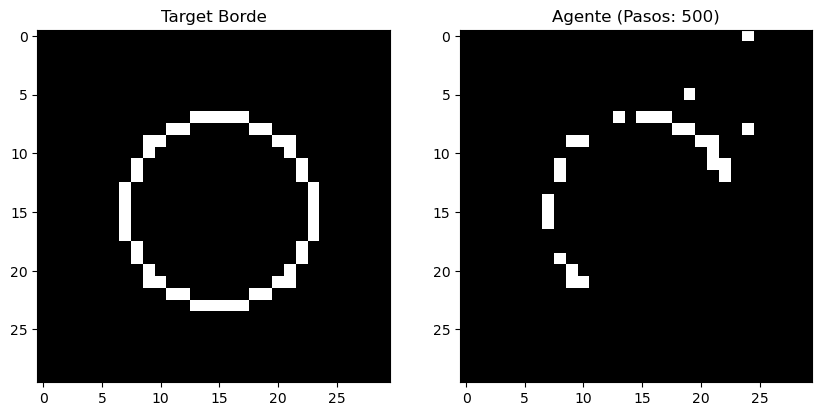

Ep 30000: Reward 1232.50, Sim 49.1%, Pasos 500


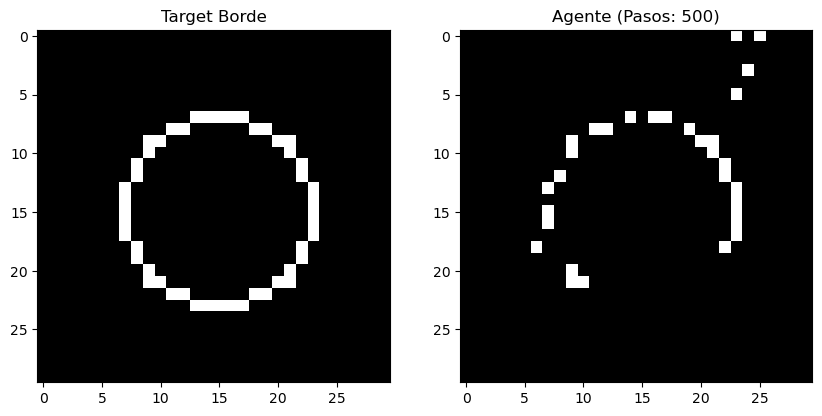

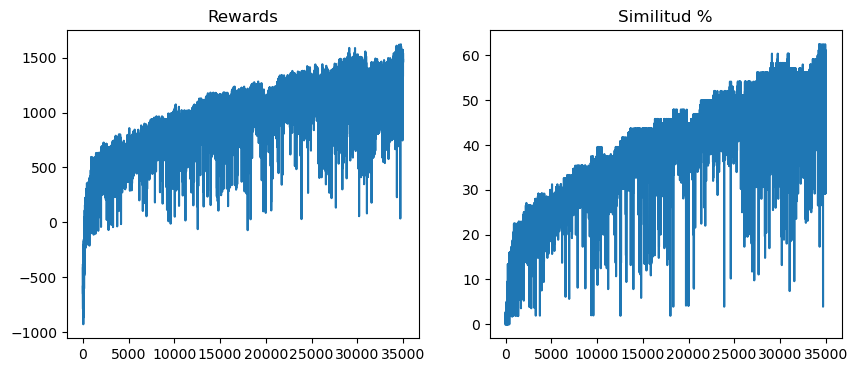

Mejor reward: 1597.24 en ep 34283 (sim 62.5%)
Guardado BEST: q_best_circulo_borde.pkl (mejor precisión)
circulo_borde listo (sim 56.9%)


In [12]:
def entrenar(agente, lienzo, fig, episodios=EPISODIOS, patience=PATIENCE):
    rewards = []
    sims = []
    best_sim = 0
    best_epoch = 0
    best_reward = 0
    no_improve_count = 0
    best_q = None  # Nuevo: Copia Q en mejor sim

    for ep in range(episodios):
        current_epsilon = max(EPSILON_MIN, EPSILON_INITIAL - DECAY_RATE * ep)
        state = lienzo.reset()
        total_r = 0
        done = False
        while not done:
            action = agente.elegir_accion(state, current_epsilon)
            next_state, r, done = lienzo.step(action, fig)
            agente.update(state, action, r, next_state, done)
            state = next_state
            total_r += r
        sim = fig.similitud(lienzo.canvas)
        rewards.append(total_r)
        sims.append(sim)

        if ep % 10000 == 0:
            #avg_r = total_r / lienzo.step_count if lienzo.step_count > 0 else 0
            print(f"Ep {ep}: Reward {total_r:.2f}, Sim {sim:.1f}%, Pasos {lienzo.step_count}")
            lienzo.render_comparison(fig)

        # Early stopping + Best track
        if sim > best_sim:
            best_sim = sim
            best_epoch = ep
            best_reward = total_r
            no_improve_count = 0
            best_q = dict(agente.q_table.copy())  # Nuevo: Copia Q en este momento
            #print(f"Mejor sim: {best_sim:.1f}% en ep {ep}")
        else:
            no_improve_count += 1
            if no_improve_count >= patience:
                print(f"Early stopping en ep {ep}: No mejora en {patience} eps. Mejor: {best_sim:.1f}% en ep {best_epoch}")
                break

        if sim > 85:
            print(f"¡Aprendido en {ep}! (Mejor reward: {best_reward:.2f})")
            break

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.plot(rewards); plt.title('Rewards')
    plt.subplot(1,2,2); plt.plot(sims); plt.title('Similitud %')
    plt.show()

    print(f"Mejor reward: {best_reward:.2f} en ep {best_epoch} (sim {best_sim:.1f}%)")
    if best_q is not None:
        agente.guardar_best(best_q, fig.nombre)  # Nuevo: Guarda best Q
    return sims[-1]

# Manual
fig = Figura()
fig.generar_borde_circulo()
lienzo = Lienzo()
agente = Agente()
final_sim = entrenar(agente, lienzo, fig, PATIENCE)   
print(f"{fig.nombre} listo (sim {final_sim:.1f}%)")

Cargado BEST: q_best_circulo_borde.pkl


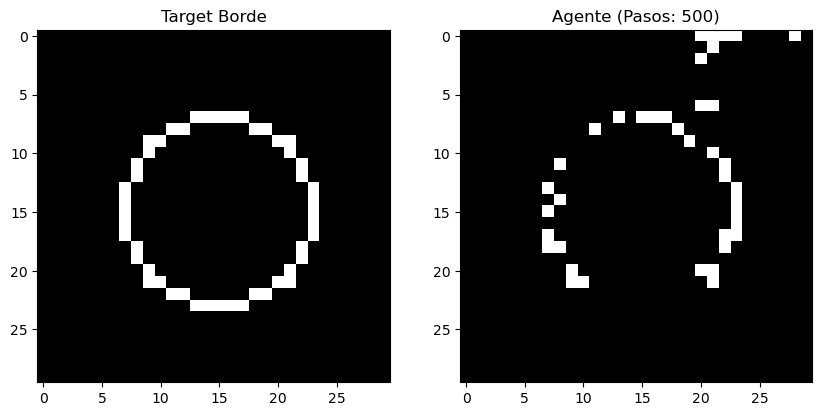

circulo_borde: Sim 40.3%, Pasos 500


In [15]:
def dibujar_aprendida(nombre):
    agente = Agente()
    agente.cargar_best(nombre)
    fig = Figura()
    if 'circulo' in nombre:
        fig.generar_borde_circulo()
    elif 'cuadrado' in nombre:
        fig.generar_borde_cuadrado()
    elif 'triangulo' in nombre:
        fig.generar_borde_triangulo()
    elif 'rectangulo' in nombre:
        fig.generar_borde_rectangulo()
    elif 'linea' in nombre:
        fig.generar_borde_linea()
    lienzo = Lienzo()
    state = lienzo.reset()
    done = False
    while not done and lienzo.step_count < MAX_STEPS:
        action = agente.elegir_accion(state)
        next_state, _, done = lienzo.step(action, fig)
        state = next_state
    sim = fig.similitud(lienzo.canvas)
    lienzo.render_comparison(fig)
    print(f"{nombre}: Sim {sim:.1f}%, Pasos {lienzo.step_count}")

dibujar_aprendida('circulo_borde')  # Cambia nombre

Test casa:
Cargado BEST: q_best_rectangulo_borde.pkl
Cargado BEST: q_best_circulo_borde.pkl


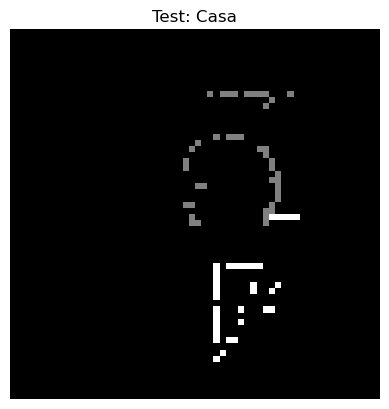

Funciones listas. Agrega a COMPOSITES para app.


In [23]:
def componer_casa():
    try:
        agente_cuad = Agente()
        agente_cuad.cargar_best('cuadrado_borde')  # Usa best Q
        agente_tri = Agente()
        agente_tri.cargar_best('triangulo_borde')  # Usa best Q
    except FileNotFoundError:
        print("Error: Entrena best para cuadrado/triángulo primero.")
        return np.zeros((60, 60))

    big_size = 60
    big_canvas = np.zeros((big_size, big_size))

    # Cuadrado (pared abajo)
    fig_cuad = Figura()
    fig_cuad.generar_borde_cuadrado()
    lienzo_cuad = Lienzo(GRID_SIZE)
    state = lienzo_cuad.reset()
    done = False
    for _ in range(MAX_STEPS):
        action = agente_cuad.elegir_accion(state)
        next_state, _, done = lienzo_cuad.step(action, fig_cuad)
        state = next_state
        if done: break
    offset_cuad = (25, 15)  # Abajo centro
    big_canvas[offset_cuad[0]:offset_cuad[0]+GRID_SIZE, offset_cuad[1]:offset_cuad[1]+GRID_SIZE] = lienzo_cuad.canvas

    # Triángulo (techo arriba)
    fig_tri = Figura()
    fig_tri.generar_borde_triangulo()
    lienzo_tri = Lienzo(GRID_SIZE)
    state = lienzo_tri.reset()
    done = False
    for _ in range(MAX_STEPS):
        action = agente_tri.elegir_accion(state)
        next_state, _, done = lienzo_tri.step(action, fig_tri)
        state = next_state
        if done: break
    offset_tri = (10, 15)  # Arriba centro
    big_canvas[offset_tri[0]:offset_tri[0]+GRID_SIZE, offset_tri[1]:offset_tri[1]+GRID_SIZE] += lienzo_tri.canvas * 0.5

    return big_canvas

def componer_arbol():
    try:
        agente_rect = Agente()
        agente_rect.cargar_best('rectangulo_borde')  # Tronco
        agente_circ = Agente()
        agente_circ.cargar_best('circulo_borde')  # Copa
    except FileNotFoundError:
        print("Error: Entrena best para rectangulo/circulo primero.")
        return np.zeros((60, 60))

    big_size = 60
    big_canvas = np.zeros((big_size, big_size))

    # Rectángulo (tronco abajo)
    fig_rect = Figura()
    fig_rect.generar_borde_rectangulo((10, 10), width=6, height=15)  # Delgado alto
    lienzo_rect = Lienzo(GRID_SIZE)
    state = lienzo_rect.reset()
    done = False
    for _ in range(MAX_STEPS):
        action = agente_rect.elegir_accion(state)
        next_state, _, done = lienzo_rect.step(action, fig_rect)
        state = next_state
        if done: break
    offset_rect = (30, 25)  # Abajo centro
    big_canvas[offset_rect[0]:offset_rect[0]+GRID_SIZE, offset_rect[1]:offset_rect[1]+GRID_SIZE] = lienzo_rect.canvas

    # Círculo (copa arriba)
    fig_circ = Figura()
    fig_circ.generar_borde_circulo((15, 15), radio=10)  # Grande
    lienzo_circ = Lienzo(GRID_SIZE)
    state = lienzo_circ.reset()
    done = False
    for _ in range(MAX_STEPS):
        action = agente_circ.elegir_accion(state)
        next_state, _, done = lienzo_circ.step(action, fig_circ)
        state = next_state
        if done: break
    offset_circ = (10, 20)  # Arriba del tronco
    big_canvas[offset_circ[0]:offset_circ[0]+GRID_SIZE, offset_circ[1]:offset_circ[1]+GRID_SIZE] += lienzo_circ.canvas * 0.5

    return big_canvas
# Lista de composiciones (expande aquí: agrega nombres/funciones)
COMPOSITES = {
    'casa': componer_casa,
    'arbol': componer_arbol
}
# Test: Genera casa
print("Test casa:")
casa_canvas = componer_arbol()
if casa_canvas is not None:
    plt.imshow(casa_canvas, cmap='gray')
    plt.title('Test: Casa')
    plt.axis('off')
    plt.show()

print("Funciones listas. Agrega a COMPOSITES para app.")

Cargado BEST: q_best_cuadrado_borde.pkl
Cargado BEST: q_best_triangulo_borde.pkl


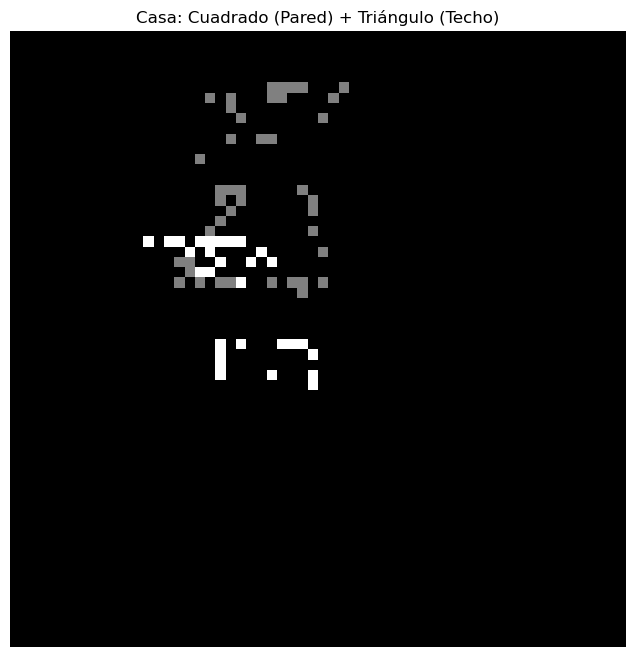

Composición generada. Ajusta offsets si superpone.


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
def componer_casa():
    # Carga agentes (asumiendo entrenados)
    try:
        agente_cuad = Agente()
        agente_cuad.cargar_best('cuadrado_borde')
        agente_tri = Agente()
        agente_tri.cargar_best('triangulo_borde')
    except:
        print("Error: Entrena cuadrado_borde y triángulo_borde primero (Celda 4).")
        return None

    big_size = GRID_SIZE * 2  # Lienzo grande 60x60
    big_canvas = np.zeros((big_size, big_size))

    # Cuadrado offset (pared abajo)
    lienzo_cuad = Lienzo(GRID_SIZE)
    state = lienzo_cuad.reset()
    done_cuad = False
    for _ in range(MAX_STEPS):
        action = agente_cuad.elegir_accion(state)
        next_state, _, done_cuad = lienzo_cuad.step(action)
        state = next_state
        if done_cuad:
            break
    # Copia offset (e.g., abajo centro)
    offset_cuad = (20, 10)  # Ajusta para posición
    big_canvas[offset_cuad[0]:offset_cuad[0]+GRID_SIZE, offset_cuad[1]:offset_cuad[1]+GRID_SIZE] = lienzo_cuad.canvas

    # Triángulo offset (techo arriba del cuadrado)
    lienzo_tri = Lienzo(GRID_SIZE)
    state = lienzo_tri.reset()
    done_tri = False
    for _ in range(MAX_STEPS):
        action = agente_tri.elegir_accion(state)
        next_state, _, done_tri = lienzo_tri.step(action)
        state = next_state
        if done_tri:  # ¡Indentado correcto!
            break
    # Copia offset (arriba del cuadrado, sin superponer mucho)
    offset_tri = (5, 10)  # Pico arriba
    big_canvas[offset_tri[0]:offset_tri[0]+GRID_SIZE, offset_tri[1]:offset_tri[1]+GRID_SIZE] += lienzo_tri.canvas * 0.5  # Overlay suave

    plt.figure(figsize=(8, 8))
    plt.imshow(big_canvas, cmap='gray', vmin=0, vmax=1)
    plt.title('Casa: Cuadrado (Pared) + Triángulo (Techo)')
    plt.axis('off')
    plt.show()
    print("Composición generada. Ajusta offsets si superpone.")
    return big_canvas

# Uso
componer_casa()